В цьому наборі завдань закріпимо те, що було на лекції з Computer Vision.

# Computer Vision with PyTorch Excercises. Solution


## 1. Наведіть 3 галузі промисловості, де комп'ютерний зір використовується сьогодні (можна згадати з лекції, або провести міні-рісерч).

# Today computer vision methods are used in various industries. Here just three examples:
- photo/video processing
- self-driving cars
- callories calculation apps

## 2. Виділіть 20 хвилин аби ознайомитись та переглянути сайт [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

* Завантажте власне будь-яке зображення за допомогою кнопки Upload" на сайті та подивіться, що відбувається на кожному шарі CNN, коли ваше зображення проходить через нього.

Напишіть 3 пункти, що ви дізнались після цієї вправи?

From this exercize, I learned what layers does CNN contain. I've understood, that CNNs are basically consist of convolutional layers, ReLU layers and polling layers (Max pool in our case). CNN can consist of many these layers and the aim is to make data volume smaller and not to overfit the model.
In the end all data is transformed into single dimentional array in order to learn features and classify image data.

## 3. Завантажте навчальні та тестові набори даних [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).

MNIST - базовий набір даних для задач Computer Vision. Часто використовується для навчання.

- Виведіть, скільки елементів в кожному наборі.
- Покажіть формат (розмірності) кожної картинки.
- Виведіть, які класи представлені в цьому наборі даних.

In [25]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

print(
    f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # отримати тестові дані
    download=True,
    transform=ToTensor()
)


image, label = train_data[0]
classes = train_data.classes

print(f"Number of elements in train data: {len(train_data)}")
print(f"Image dimentions: {image.shape}")
print(f"Number of classes in train_data: {classes}")

PyTorch version: 2.7.0
torchvision version: 0.22.0
Number of elements in train data: 60000
Image dimentions: torch.Size([1, 28, 28])
Number of classes in train_data: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## 4. Візуалізуйте щонайменше 5 різних зразків з навчального набору даних MNIST.

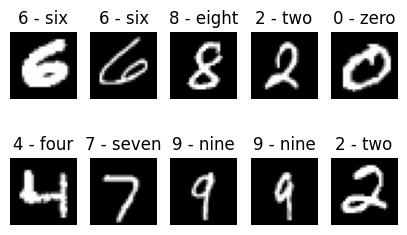

In [26]:
import matplotlib.pyplot as plt

torch.manual_seed(42)
fig = plt.figure(figsize=(5,3))
rows, cols = 2, 5

for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  
  plt.title(classes[label])
  plt.imshow(img.squeeze(), cmap="gray")
  plt.axis(False)

## 5. Перетворіть навчальні та тестові набори даних MNIST у data loaders за допомогою `torch.utils.data.DataLoader`, встановіть `batch_size=32`.
- Покажіть, яку форму даних вертають дата лоадери.

In [30]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches {BATCH_SIZE} each")
print(f"Length of test dataloader: {len(test_dataloader)} batches {BATCH_SIZE} each")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x3169a26c0>, <torch.utils.data.dataloader.DataLoader object at 0x3169a0560>)
Length of train dataloader: 3750 batches 16 each
Length of test dataloader: 625 batches 16 each


## 6. Відтворіть `ModelV2`, яку ми розглядали на лекції
Це до слова та сама модель з [сайту CNN Explainer](https://poloclub.github.io/cnn-explainer/), також відома як TinyVGG і вона здатна навчатися на наборі даних MNIST.

Напишіть клас моделі.

In [33]:
# This code snippet defines a PyTorch neural network model class named `MNISTModelV2` that implements an architecture inspired by TinyVGG. Here's a breakdown of what the code is doing:
class MNISTModelV2(nn.Module):
	"""
	Model architecture, which copies TinyVGG from:
	https://poloclub.github.io/cnn-explainer/
	"""
 
	def __init__(self, input_spape: int, hidden_units: int, output_shap: int):
		super().__init__()
		self.block_1 = nn.Sequential(
			nn.Conv2d(
				in_channels=input_shape,
				out_channels=hidden_units,
				kernel_size=3, 				# shape of square, which explores an image
				stride=1,					# default value
				padding=1					
			),
			nn.ReLU(),
			nn.Conv2d(
				in_channels=hidden_units,
				out_channels=hidden_units,
				kernel_size=3,
				stride=1,
				padding=1
			),
   			nn.ReLU(),
			nn.MaxPool2d(
       			kernel_size=2,
                         stride=2
            )
		)
		self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
		self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did we take in_features form?
            # This is because each layer of our network squezes and changes form of input data
            nn.Linear(
                in_features=hidden_units*7*7,
                      out_features=output_shape
            )
        )
        
	def forward(self, x: torch.Tensor):
		x = self.block_1(x)
        # print(x.shape)
		x = self.block_2(x)
        # print(x.shape)
		x = self.classifier(x)
        # print(x.shape)
		return x

## 7. Навчіть модель, яку ви побудували в попередній вправі, протягом 5 епох на CPU та GPU і подивіться, скільки часу це займе в кожному з варіантів.

## 8. Зробіть прогнози за допомогою вашої навченої моделі та візуалізуйте принаймні 5 з них, порівнюючи прогноз з цільовою міткою.

## 9. Побудуйте матрицю плутанини, порівнюючи передбачення вашої моделі з істинними мітками.

## 10. Виведіть принаймні 9 прикладів, де модель помиляється, разом з тим, якою мала бути мітка зображення.
* Після візуалізації цих прогнозів, як ви думаєте, це більше помилка моделювання чи помилка даних?
* Тобто, чи може модель працювати краще, чи мітки даних занадто близькі одна до одної, що навіть людина не може чітко розрізнити що це за цифра?

## 11. Створіть випадковий тензор форми `[1, 3, 64, 64]` і пропустіть його через шар `nn.Conv2d()` з різними налаштуваннями гіперпараметрів (ви можете вибрати будь-які налаштування), що ви помічаєте, якщо параметр `kernel_size` збільшується або зменшується?